# QuTiP example: Dynamics of a Spin Chain

This notebook is based on https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/spin-chain.ipynb .


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

 Hamiltonian:

$\displaystyle H = - \frac{1}{2}\sum_n^N h_n \sigma_z(n) - \frac{1}{2} \sum_n^{N-1} [ J_x^{(n)} \sigma_x(n) \sigma_x(n+1) + J_y^{(n)} \sigma_y(n) \sigma_y(n+1) +J_z^{(n)} \sigma_z(n) \sigma_z(n+1)]$


In [13]:
def integrate(N, h, Jx, Jy, Jz, psi0, tlist, gamma, solver):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H += - 0.5 * h[n] * sz_list[n]

    # interaction terms
    for n in range(N-1):
        H += - 0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
        H += - 0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
        H += - 0.5 * Jz[n] * sz_list[n] * sz_list[n+1]

    # collapse operators
    c_op_list = []

    # spin dephasing
    for n in range(N):
        if gamma[n] > 0.0:
            c_op_list.append(np.sqrt(gamma[n]) * sz_list[n])

    # evolve and calculate expectation values
    if solver == "me":
        result = mesolve(H, psi0, tlist, c_op_list, sz_list)
    elif solver == "mc":
        ntraj = 250 
        result = mcsolve(H, psi0, tlist, c_op_list, sz_list, ntraj)

    return result.expect

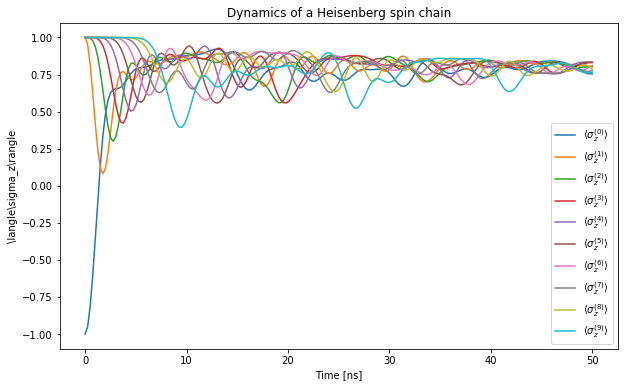

In [14]:
#
# set up the calculation
#
solver = "me"   # use the ode solver
#solver = "mc"   # use the monte-carlo solver

N = 10            # number of spins

# array of spin energy splittings and coupling strengths. here we use
# uniform parameters, but in general we don't have too
h  = 1.0 * 2 * np.pi * np.ones(N) 
Jz = 0.1 * 2 * np.pi * np.ones(N)
Jx = 0.1 * 2 * np.pi * np.ones(N)
Jy = 0.1 * 2 * np.pi * np.ones(N)
# dephasing rate
gamma = 0.01 * np.ones(N)

# intial state, first spin in state |1>, the rest in state |0>
psi_list = []
psi_list.append(basis(2,1))
for n in range(N-1):
    psi_list.append(basis(2,0))
psi0 = tensor(psi_list)

tlist = np.linspace(0, 50, 200)

sz_expt = integrate(N, h, Jx, Jy, Jz, psi0, tlist, gamma, solver)

fig, ax = plt.subplots(figsize=(10,6))

for n in range(N):
    ax.plot(tlist, np.real(sz_expt[n]), label=r'$\langle\sigma_z^{(%d)}\rangle$'%n)

ax.legend(loc=0)
ax.set_xlabel(r'Time [ns]')
ax.set_ylabel(r'\langle\sigma_z\rangle')
ax.set_title(r'Dynamics of a Heisenberg spin chain');

